# Прогнозирование оттока клиентов сети фитнес - центров.

Помочь сети фитнес-центров «Культурист-датасаентист» разработать стратегию взаимодействия с клиентами на основе аналитических данных. Задача — провести анализ и подготовить план действий по удержанию клиентов:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    - 1) выделить целевые группы клиентов;
    - 2) предложить меры по снижению оттока;
    - 3) определить другие особенности взаимодействия с клиентами.

## Предобработка данных.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

In [2]:
try:
    url = 'https://drive.google.com/file/d/11fJ_IHomNGCSzQzsT3_nIHQbJI3GJBng/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path)
except:
    raise

Импортируем основные библиотеки и прочтем датасет.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.shape

(4000, 14)

В датасете 4000 записей. На первый взгляд пропусков нет ни в одном поле.

In [5]:
df.columns = map(str.lower, df.columns)

Приведем наименования столбцов к строчным буквам для удобства.

In [6]:
cols = df.columns[:14]
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    print('{} - {}%'.format(col, pct_missing*100))

gender - 0.0%
near_location - 0.0%
partner - 0.0%
promo_friends - 0.0%
phone - 0.0%
contract_period - 0.0%
group_visits - 0.0%
age - 0.0%
avg_additional_charges_total - 0.0%
month_to_end_contract - 0.0%
lifetime - 0.0%
avg_class_frequency_total - 0.0%
avg_class_frequency_current_month - 0.0%
churn - 0.0%


In [7]:
df.isna().mean().reset_index().round(2)

,index,0
0,gender,0.0
1,near_location,0.0
2,partner,0.0
3,promo_friends,0.0
4,phone,0.0
5,contract_period,0.0
6,group_visits,0.0
7,age,0.0
8,avg_additional_charges_total,0.0
9,month_to_end_contract,0.0


Проверим наличие пропусков.  Значений n/a нет ни в одном поле.

In [8]:
df['gender'].value_counts()

1    2041
0    1959
Name: gender, dtype: int64

В поле gender нет пропусков, соотношение пола 1 и пола 2 - почти равное.

In [9]:
df['near_location'].value_counts()

1    3381
0     619
Name: near_location, dtype: int64

Поле near_location не нуждается в предобработке, значения корректны. Доля клиентов, живущих или работающих рядом с фитнес-центром - примерно 85%

In [10]:
df['partner'].value_counts()

0    2053
1    1947
Name: partner, dtype: int64

В выборке почти равное количество корпоративных и некорпоративных абонентов.

In [11]:
df['promo_friends'].value_counts()

0    2766
1    1234
Name: promo_friends, dtype: int64

В выборке - порядка 30% клиентов, привлеченных в рамках акции "Приведи друга".

In [12]:
df['phone'].value_counts()

1    3614
0     386
Name: phone, dtype: int64

10% клиентов не указали свой номер телефона в анкете.

In [13]:
df['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

Из распределения видно, что клиенты предпочитают месячные абонементы, таких клиентов больше, чем предпочитающих годовой и полугодовой абнемент. Доля клиентов с полугодовым абонементов - минимальная. Чуть больше клиентов - с годовым абонементом. Отток клиентов с месячным абонементом может быть выше (гипотеза), т.к. купившие абонемент на длительный период клиенты будут стараться оправдать средства, вложенные в абонемент. Данную гипотезу будет интересно проверить после построения моделей.

In [14]:
df['group_visits'].value_counts()

0    2351
1    1649
Name: group_visits, dtype: int64

In [15]:
df['age'].value_counts()

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: age, dtype: int64

In [16]:
df['age'].describe()

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64

В выборке - клиенты от 18 лет до 41 года. Средний (и медианный) возраст - 29 лет. Стандартное отклонение -3,2 года. Близость значений среднего и медианы и низкое значение стандартного отклонения говорят о близости данных к нормальному распределению.

In [17]:
df['month_to_end_contract'].value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

У большинства клиентов в выборке абонемент заканчивается через месяц. Можно предположить, что большинство в этой группе -  клиенты с месячным абонементом. Следующая группа - предположительно, в большинстве, клиенты с полугодовым абонементом. Далее - группа, у которой абонемент заканчивается через 12 месяцев. Т.к. в условиях задачи ничего не сказано об абонементах, длительностью больше года, все эти клиенты должны быть пользователями годовых абонементов. Далее идут небольшие группы, у которых абонемент заканчивается от 11 до 2 месяцев, это пользователи полугодовых и годовых абонементов.

In [18]:
df['lifetime'].value_counts()

1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
14     24
15     24
16     15
17     11
19      7
20      7
18      7
21      5
24      2
22      2
26      2
23      2
29      1
27      1
31      1
Name: lifetime, dtype: int64

Большинство клиентов - это относительно недавно обратившиеся в клуб абоненты (до года). Больше всего тех, кто впервые обратился месяц назад. Чем больший срок обращения - тем меньшее количество клиентов ему соответствует.

In [19]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

В выборке - примерно 30% ушедших клиентов и 60% - оставшихся.

## Исследовательский анализ данных.

In [20]:
for col in df.columns:
    print(df[col].describe())

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64
count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64
count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64
count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64
c

Проанализируем средние значения и стандартные отклонения значений. Для части полей выводы уже сделаны выше, в блоке предобработки. Ниже - выводы по показателям журнала посещений и покупок:

- avg_additional_charges_total. Суммарная выручка от прочих услуг на 1 клиента, в среднем, составляет 146 условных единиц (медианное значение - 136 единиц). Стандартное отклонение велико, 96 условных единиц. Это говорит о том, что дополнительные услуги распределены между клиентами неравномерно, кто-то пользуется, а кто-то  - нет. Для более точных выводов необходим дополнительный анализ распределения.
- lifetime. Среднее время до окончания контракта - 3,7 мес, медиана - 3 месяца.
- avg_class_frequency_total. Средня частота посещений за неделю - 1,8 посещения, как и медиана. Стандартное отклонение - 0,97, что является достаточно высоким значением для этого ряда данных (максимум - 6 раз в неделю). Более точные выводы о тенденциях средней посещаемости можно будет сделать посмотрев на гистограмму распределения.
- avg_class_frequency_current_month. Среднее - 1,76. Медиана - 1,71. Стандартное отклонение - 1,05. Тенденция средней частоты посещений в неделю за предыдущий месяц и средней частоты посещений за неделю одинакова, в среднем - 1,7 - 1,8 раз в неделю. Но небольшая тенденция к снижению есть.

In [21]:
data = df.groupby('churn').mean()
data.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Проанализируем и сравним средние показатели ушедших и оставшихся клиентов.

- gender. Соотношение полов у ушедших и оставшихся практически идентично, 51%, что позволяет предположить, что пол не является причиной, влияющей на решение уйти.
- near_location. В группе ушедших - в среднем 76% тех, для кого клуб находится в районной доступности. Среди оставшихся - 87%. Можно выдвинуть гипотезу о том, что местоположение играет роль в принятии решения о дальнейшем посещении клуба.
- partner. Среди ушедших - 35% корпоративных клиентов. Среди оставшихся - 53%. Можно выдвинуть гипотезу о влиянии наличия корпоративной карты на решение о дальнейшем посещении клуба.
- promo_friends. Среди оставшихся - 35% участвовали в акции "приведи друга". Среди ушедших - всего лишь 18%.
- phone. Доля пользователей с наличием телефона в анкете одинакова и среди ушедших и среди оставшихся.
- contract_period. Средняя длительность контракта среди ушедших - 1,72 мес. Средняя длительность среди оставшихся - 5,7 мес. Можно сделать выводы о том, что клиенты с долгосрочным абонементом менее склонны к решению прекратить посещение клуба, чем люди с месячным абонементом.
- group_visits. 26% ушедших посещали групповые занятия. 46% оставшихся - посещают.
- age. Средний возраст ушедших - 26,9 лет. Средний возраст оставшихся - 29,9. Можно предположить, что старшее поколение менее склонно часто менять фитнес-клубы или отказываться от курса на здоровый образ жизни.
- avg_additional_charges_total. Средний чек на допуслуги оставшихся - 158 условных единиц. Средний чек ушедших - 115 условных единиц. Гипотеза: клиенты, серьезно занимающиеся спортом нуждаются в комплексе прочих товаров и услуг фитнес-центров.
- month_to_end_contract. Тенденция очень похожа на ситуацию с contract_period. Схожи средние длительности ушедших и оставшихся. Можно сделать выводы о том, что клиенты с долгосрочным абонементом менее склонны к решению прекратить посещение клуба, чем люди с месячным абонементом.
- lifetime. Ситуация полностью аналогична month_to_end_contract и contract_period.
- avg_class_frequency_total. Средняя частота посещения занятий в неделю у оставшихся - 2 раза, у ушедших - 1,5 раза. Тенденция показывает, что реже посещающие более склонны к решению прекратить посещение клуба.
- avg_class_frequency_current_month. Тенденция аналогична показателю avg_class_frequency_total, но различие выражено более ярко. Для оставшихся клиентов среднее количество посещений в неделю - 2, для ушедших - 1. Т.е. в последний месяц склонные к уходу сокращают количество посещений примерно в 2 раза.

In [22]:
staying = df.query('churn==0')
gone = df.query('churn==1')

Выделим в отдельные датасеты ушедших и оставшихся.

In [23]:
cols_staying = staying.columns[:13]
cols_gone = gone.columns[:13]

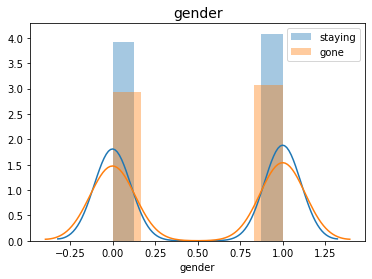

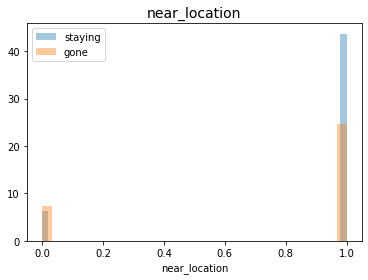

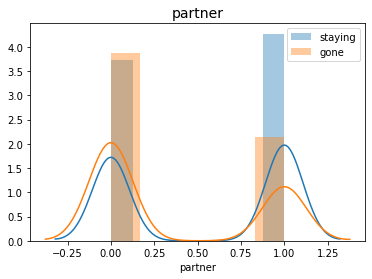

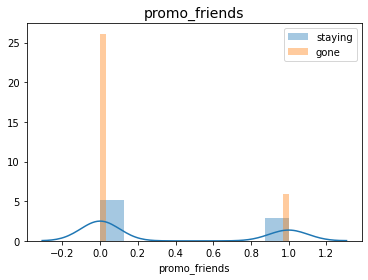

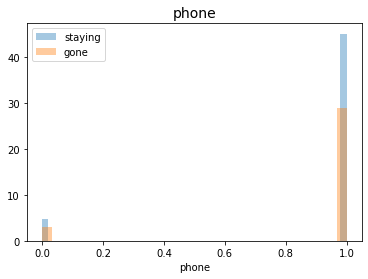

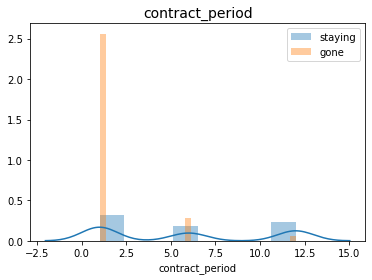

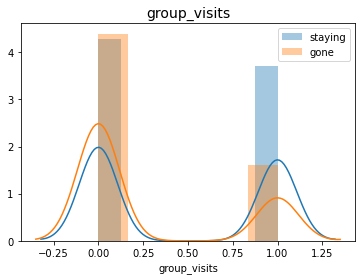

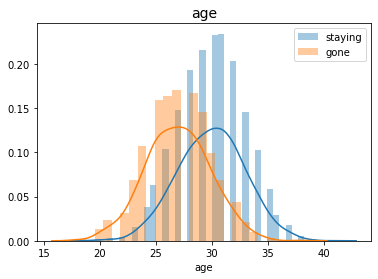

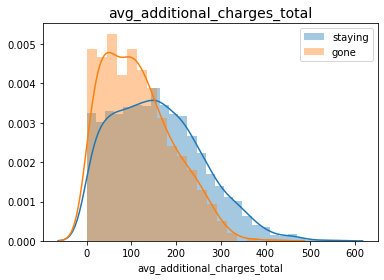

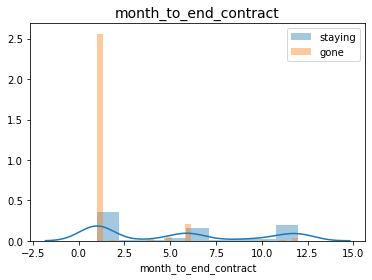

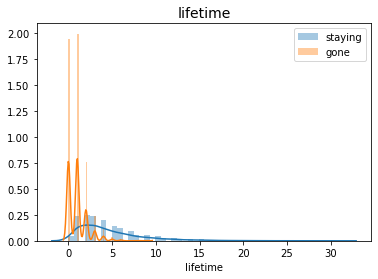

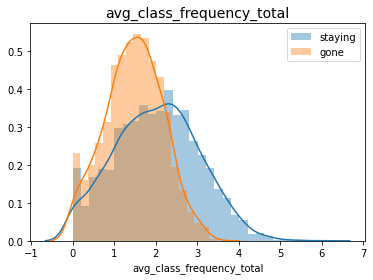

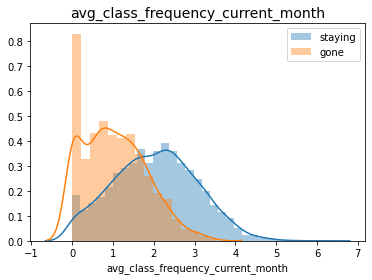

In [24]:
warnings.simplefilter('ignore')
for col in cols_staying:
    sns.distplot(staying[col])
    sns.distplot(gone[col])
    plt.legend(['staying','gone'])
    plt.title(col,fontsize = 14)
    plt.show();        

Построим графики распределений и проанализируем их.

- age. Распределение оставшихся клиентов более равномерное и ближе к классическому нормальному распределению. На графике распределения ушедших клиентов датасет чуть скошен влево и он меньше похож на нормальное распределение.
- avg_additional_charges_total. У оставшихся клиентов средний чек распределен более равномерно, чем у ушедших. Основная плотность у ушедших - до 150 условных единиц. У оставшихся - до 230-240 единиц.
- avg_class_frequency_total. Датасет оставшихся распределен более равномерно, достаточно плотное распределение в районе от 1 до 3 посещений в неделю. У ушедших - 1-2 посещения.
- avg_class_frequency_current_month. Различие с avg_class_frequency_total более сильное. тенденция для оставшихся повторяется, наиболее плотное распределение - 1-3 посещения в неделю. Для ушедших - от 0 до 1,5 посещений в неделю.

In [25]:
matrix = df.corr()

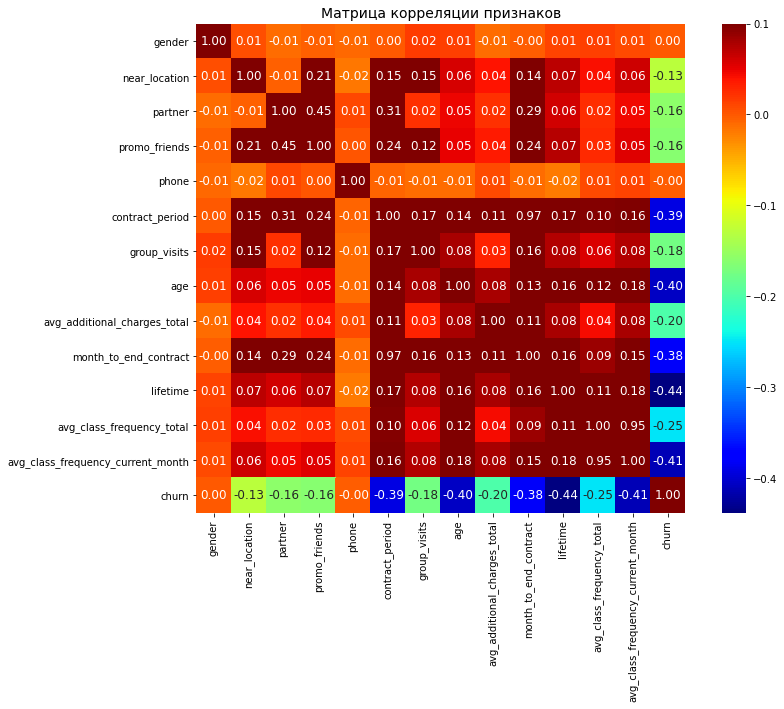

In [26]:
plt.figure(figsize=(13, 9))
sns.heatmap(matrix, annot = True, square = True, fmt='.2f', cmap ='jet', vmax=.1,annot_kws={'fontsize':12}) 
plt.title('Матрица корреляции признаков',fontsize = 14)
plt.show()

Построим и проанализируем матрицу корреляций. Для целей анализа используем следующие общепринятые градации корреляции:
- от 0 до 0,3 -очень слабая,
- от 0,3 до 0,5 - слабая,
- от 0,5 до 0,7 - средняя,
- от 0,7 до 0,9 - высокая,
- от 0,9 до 1 - очень высокая.

По результатам анализа корреляционной матрицы можно сделать следующие выводы:
- gender. Показатель не коррелирует ни с одним показателем, можно сделать вывод о том, что пол клиента не влияет на прочие показатели
- near location. Есть слабая корреляция с событием первоначальной записи по акции, периодом контракта и групповыми занятиями. И слабая отрицательная корреляция с оттоком
- partner. Наличие корпоративной карты средне коррелирует с записью по акции "Приведи друга" и слабо коррелирует с длительностью абонемента и количеством времени до окончания контракта. И слабая отрицательная корреляция с оттоком
- promo_friends. Средне коррелирует с фактом наличия корпоративной карты. Слабо коррелирует с периодом конракта и количеством месяцев до окончания контракта и с локализацией клиента.
- Наличие телефона. Не коррелирует ни с чем.
- contract_period. Сильная корреляция с month_to_end_contract (величины прямо зависимы). Очень слабо коррелирует почти со всеми показателями (со всеми, кроме пола и наличия телефона в анкете). Слабая обратная корреляция с оттоком.
- group_visits. Слабая корреляция с near_location, promo_friends, contract_period и month_to_end_contract
- age. Очень слабо коррелирует с временными показателями, слабая обратная корреляция с показателем оттока.
- avg_additional_charges_total. Очень слабо коррелирует с периодом контракта.
- мonth_to_end_contract. Повторяет тенденцию корреляции contract_period.
- lifetime. Слабая корреляция с периодом контракта, возрастом и среднемесячным количеством посещений.
- avg_class_frequency_total. Прямая связь с avg_class_frequency_current_month. Слабая корреляция с периодом контракта, возрастом и lifetime.
- avg_class_frequency_current_month. Дублирует корреляции avg_class_frequency_total. Но более сильная корреляция с с периодом контракта, возрастом и lifetime. Более сильная обратная корреляция с churn.

## Модель прогнозирования оттока клиентов.

Для линейных моделей взаимная корреляция признаков нежелательна. По результатам анализа корреляционной матрицы таких признаков несколько: contract_period и month_to_end_contract, avg_class_frequency_total и avg_class_frequency_current_month. Удалим из датасета avg_class_frequency_current_month и month_to_end_contract.

In [27]:
df = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1)

In [28]:
X=df.drop('churn', axis = 1)
y=df['churn']

Разделим данные на признаки и целевую переменную.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Разобьем данные на обучающую и валидационную выборку.

In [30]:
lr_model = LogisticRegression(solver='liblinear')

Зададим алгоритм для модели.

In [31]:
lr_model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Обучим модель.

In [32]:
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

Сделаем прогнозы.

In [33]:
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0)

Зададим алгоритм для модели случайного леса.

In [34]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

Обучим модель.

In [35]:
rf_predictions = rf_model.predict(X_test)

In [36]:
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

Сделаем прогнозы.

In [37]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred))) 
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [38]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.83
	Recall: 0.80
	F1: 0.81
	ROC_AUC: 0.96


In [39]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для случайного леса:')

Метрики для случайного леса:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79
	F1: 0.80
	ROC_AUC: 0.95


Выведем метрики логистической регрессии и случайного леса и сравним их. 
- Доля правильных ответов на 1% выше при применении алгоритма случайного леса. Но и логистическая регрессия дает долю меньше всего лишь на 1%, различие невелико. 
- Метрика precision говорит, какая доля прогнозов относительно 1 класса верна (доля правильных ответов только в целевом классе, в нашем случае - доля ушедших клиентов). Она одинакова и для случайного леса и для логистической регрессии.
- Метрика recall более точна для логистической регрессии.
- Метрика F1 более точна для логистической регрессии.
- Метрика ROC_AUC идентична для обеих моделей.

## Кластеризация клиентов.

In [40]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [41]:
linked = linkage(X_sc, method = 'ward')

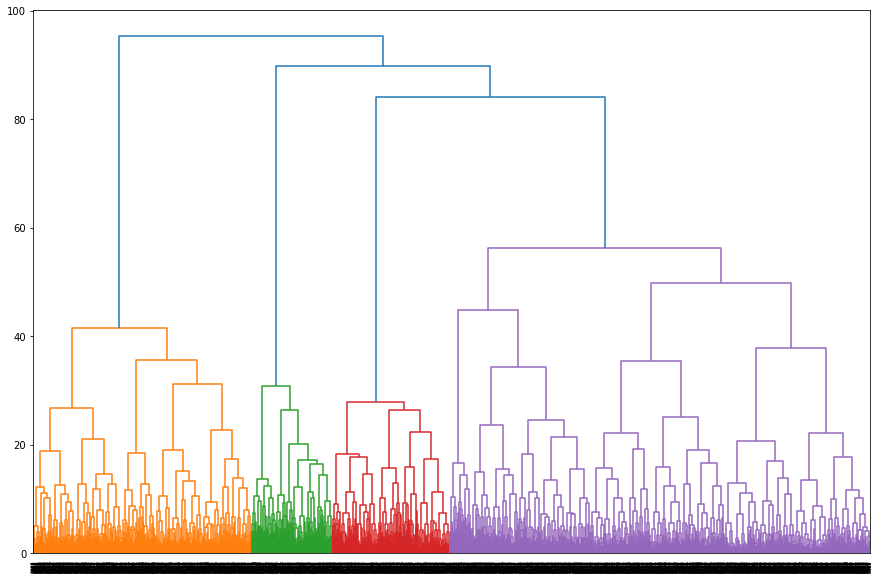

In [42]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Построим дендрограмму, чтобы оценить количество кластеров.
Предложенное оптимальное число кластеров 4. Но в учебных целях для унификации результатов зададим для модели K-means 5 кластеров.

In [43]:
km = KMeans(n_clusters = 5, random_state = 0)

Зададим параметр n_clusters для k-means равный 5.

In [44]:
labels = km.fit_predict(X_sc)

Спрогнозируем кластеры для наблюдений.

In [45]:
df['cluster_km'] = labels

Сохраним метки кластера в столбце cluster_km исходного датасета.

In [46]:
print('Метрика силуэта: {:.2f}'.format(silhouette_score(X_sc, labels)))

Метрика силуэта: 0.13


Посчитаем метрику силуэта для того, чтобы оценить качество кластеризации. Метрика силуэта интерпретируется следующим образом: чем ближе silhouette_score к 1, тем качественнее кластеризация, т.е. объект своего кластера похож на свой кластер больше, чем на чужой. В нашем слечае значение равно 0,14, что является невысоким значением. Но в реальной жизни объекты редко имеют четкое разделение и выраженную структуру. Проанализируем средние значения для кластеров, для поиска дополнительных закономерностей. 

In [47]:
clusters_mean_scoers = df.groupby('cluster_km').agg({'gender' :'mean','near_location' :'mean','partner' :'mean','promo_friends' :'mean','phone' :'mean','contract_period' :'mean','group_visits' :'mean','age' :'mean','avg_additional_charges_total' :'mean','lifetime' :'mean','avg_class_frequency_total' :'mean','churn' :'mean', 'phone':'count'}).rename(
    columns={'phone':'q-ty'})
clusters_mean_scoers

,gender,near_location,partner,promo_friends,q-ty,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.502683,0.000000,0.490161,0.078712,559,3.000000,0.232558,28.708408,137.385192,3.007156,1.768159,0.400716
1,0.486867,0.996248,0.943715,0.883677,1066,7.660413,0.523452,29.474672,149.409166,4.057223,1.912481,0.117261
2,0.561614,0.996728,0.267176,0.050164,917,5.241003,0.533261,30.958561,186.697490,5.778626,2.400164,0.023991
3,0.488806,1.000000,0.223881,0.078358,1072,2.082090,0.286381,27.584888,116.455656,1.933769,1.466695,0.547575
4,0.523316,0.862694,0.471503,0.305699,386,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Сделаем обзор кластеров и сравним их средние значения.

- Клиенты первого кластера характеризуются почти равным разделением полов (как и прочие кластеры, в этой связи предлагается не упоминать в анализе данный признак, как не влияющий на поведение пользователей). Почти все пользователи этого кластера проживают или работают рядом с клубом. Самое большое количество пользователей этого кластера являются корпоративными клиентами. 89% клиентов этого кластера участвовали в программе "Приведи друга". Этот кластер - второй по численности. Длительность контракта этого кластера - 7,6 месяцев, что говорит о серьезности намерений клиентов. Половина клиентов посещает групповые занятия. Средний возраст участников кластера - 28,7 лет. Средние расходы на дополнительные услуги высоки и занимают 1 место из 5. Средний lifetime - первый по длительности, 4,3. Частота посещений - на 1 месте, 1,97 раз в неделю. Отток -  самый низкий, 12% . По совокупности характеристик предлагается охарактеризовать этот кластер "Премиум".

- Третий кластер - третий по массовости, 871 клиент. Они также проживают или работают в районной доступности. Всего 25% является корпоративными клиентами. Почти никто из них не участвовал в программе "Приведи друга". Средний период контракта этого кластера 4,5 месяцев. Максимальное количество клиентов этого кластера посещают групповые занятия, 100%. Средний возраст - самый высокий, 29,5 лет. Расходы на допуслуги 148 у.е. lifetime - 3,7 мес. Высокий показатель среднего количества посещений в неделю, 1,94. Малый показатель оттока, 20%.

- Кластер 0 - почти самый немногочисленный (за исключением 4 кластера), 561 клиент. Никто из них не проживает и не работает в районной доступности с фитнес-центром. Половина из них - участники корпоративной партнерской программы. 7% (незначительная доля) участвовали в акции "Приведи друга". Средний период контракта клиентов данного кластера - 3 месяца, почти самый низкий показатель. Всего 23% клиентов посещают групповые занятия, это наименьший показатель среди всех кластеров. Средний возраст участников - 28,7 лет. Расходы на допуслуги почти самые низкие, 137 у.е. Lifetime - почти идентичен contract_period. avg_class_frequency_total - 1,77 раз в неделю, также почти самый низкий показатель посещаемости. Отток клиентов этого кластера - 40%. По совокупности факторов можно охарактеризовать как нестабильный и склонный к оттоку кластер. Исходя из совокупности факторов можно рекомендодвать руководству клуба не расходовать ресурсы на программы по удержанию клиентов этого кластера.

- Кластер 4 - самый немногочисленный, 386 клиентов. 86% клиентов проживает и работает в районной доступности с фитнес-центром. 30% являются корпоративными клиентами. contract_period - средний по длительности, 4,7 мес. 42% клиентов посещают групповые занятия. Средний возраст - 29 лет. Стоимость допуслуг - 144 у.е., это средний показатель. lifetime - почти 4 месяца. Частота посещений в месяц неплохая, 1.85 раз. Отток - 26,6%. По совокупности факторов кластер достаточно перспективный, можно попробовать провести мероприятия по удержанию клиентов. Также, по совокупности параметров этот кластер ближе к нулевому кластеру, скорее всего, если при кластеризации следовать рекомендованному дендрограммой n_clusters = 4, этот кластер был бы в большей степени поглощен треьим кластером (гипотеза).

- Кластер 2 - самый многочисленный. Все клиенты проживают или работают в районной доступности фитнес-центра. Всего 23% из них - корпоративные клиенты. Почти никто не участвовал в акции "Приведи друга". Период контракта - краткосрочный, почти 2,8 месяца. Скорее всего в числе клиентов этого кластера много посетителей с месячным абонементом. Никто из них не посещает групповые занятия. Средний возраст - низкий, 28,7 лет. Расходы на дополнительные услуги - низкие, 143 у.е. Lifetime - 3,3 месяца. Средняя частота посещений - 1,8 раза в неделю. Отток почти самый высокий, 38%. По совокупности факторов рекомендуется провести мероприятия по удержанию клиентов. Причины - многочисленность кластера (уходит много потенциальных клиентов) и 100-% проживание в районе нахождения клуба (очень важный фактор). Проведение целевых промо может позволить удержать часть клиентов, уменьшить отток и увеличить выручку фитнес-центра.

Проанализируем распределения признаков для кластеров. Предлагается не анализировать распределение бинарных признаков, в обзоре кластеров есть эта информация.

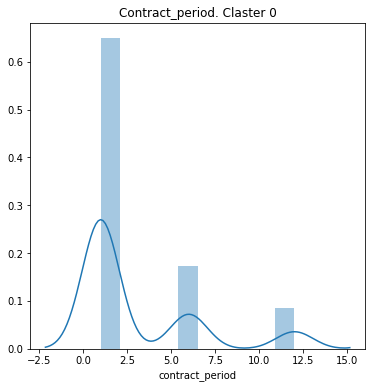

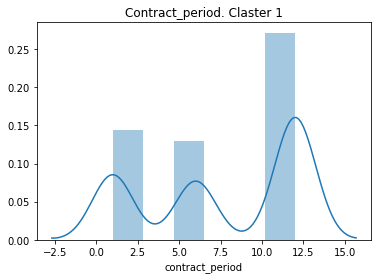

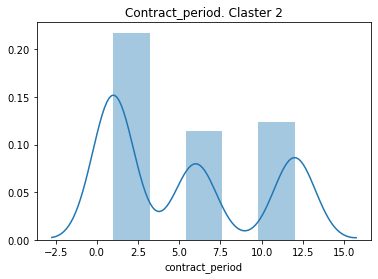

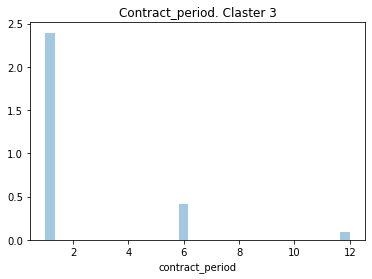

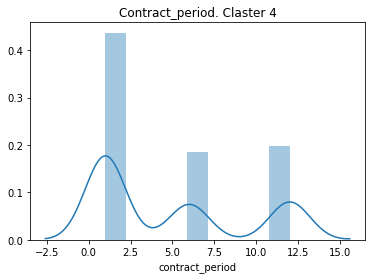

In [48]:
plt.figure(figsize=(6, 6))
for i in range(5):    
    sns.distplot(df.query('cluster_km==@i')['contract_period'])
    plt.title('Contract_period. Claster '+ str(i))    
    plt.show()

Проанализируем распределение периодов контрактов в разрезе кластеров. В нулевом, втором, третьем и четвертом кластере больше всего краткосрочных месячных контрактов. В первом, премиальном кластере - преимущественно догосрочные контракты. Меньше всего долгосрочных контрактов - в проблемном втором кластере.

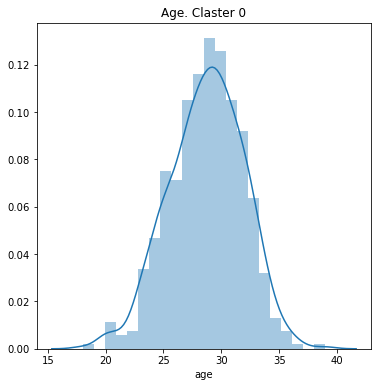

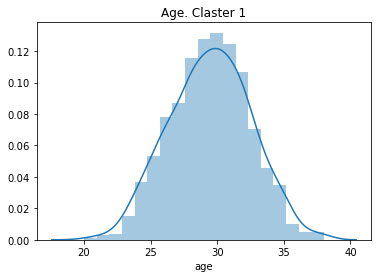

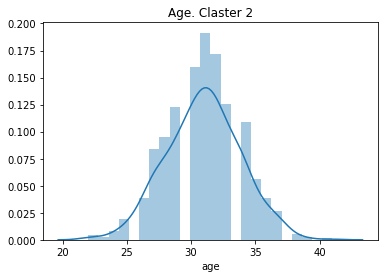

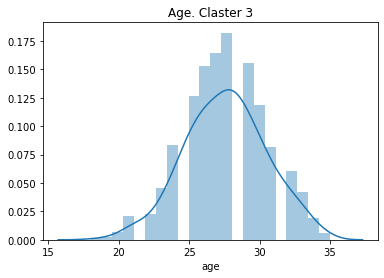

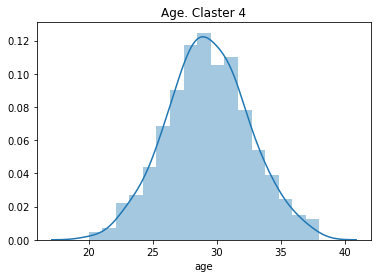

In [49]:
plt.figure(figsize=(6, 6))
for i in range(5):    
    sns.distplot(df.query('cluster_km==@i')['age'])
    plt.title('Аge. Claster '+ str(i))    
    plt.show()

Наиболее близкое к нормальному распределение - в нулевом кластере. Относительно ровное распределение в 4 кластере, но область более широкая, чем в нулевом. Распределение кластера 2 - самое неравномерное. Плотность распредеелния 1 кластера достаточно широкая, от 28 до 33. В 3 кластере датасет смещен влево, больше молодых клиентов.

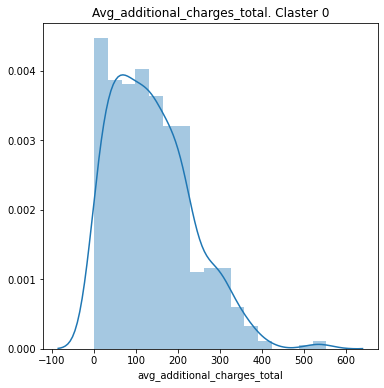

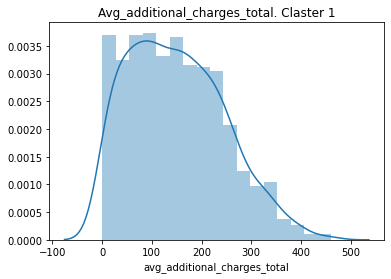

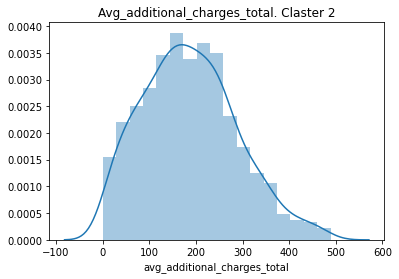

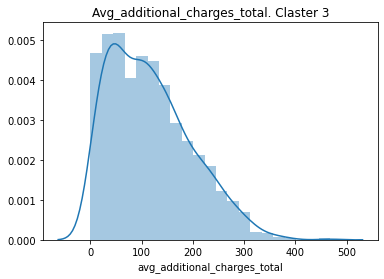

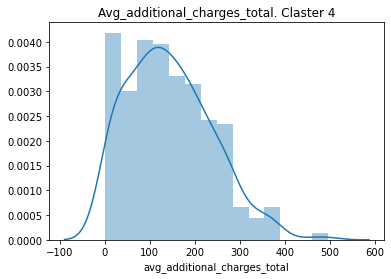

In [50]:
plt.figure(figsize=(6, 6))
for i in range(5):    
    sns.distplot(df.query('cluster_km==@i')['avg_additional_charges_total'])
    plt.title('Avg_additional_charges_total. Claster '+ str(i))    
    plt.show()

Распределение дополнительных расходов равномернее всего выглядит для 2 и 1 кластера. В нулевом кластере максимально плотное распределение - до 210 условных единиц, но с самым маленьким разбросом, после 210 у.е. идет резкий спад количества пользователей допуслуг.

## Общие выводы и рекомендации.

### Выводы

- В выборке - примерно 30% ушедших клиентов и 60% - оставшихся.
- Основные посетители фитнес-клуба - клиенты от 18 лет до 41 года. Средний (и медианный) возраст - 29 лет. 
- У большинства клиентов в выборке абонемент заканчивается через месяц. Можно предположить, что большинство в этой группе - клиенты с месячным абонементом. Следующая группа - предположительно, в большинстве, клиенты с полугодовым абонементом. Далее - группа, у которой абонемент заканчивается через 12 месяцев.
- Большинство клиентов - это относительно недавно обратившиеся в клуб абоненты (до года).
- Средняя выручка от прочих услуг на 1 клиента, в среднем, составляет 146 условных единиц (медианное значение - 136 единиц).
- Среднее время до окончания контракта - 3,7 мес, медиана - 3 месяца.
- Средня частота посещений за неделю - 1,8 посещения.

Сравнительные показатели ушедших и оставшихся клиентов:

- Соотношение полов у ушедших и оставшихся практически идентично, 51%, что позволяет предположить, что пол не является причиной, влияющей на решение уйти.
- В группе ушедших - в среднем 76% тех, для кого клуб находится в районной доступности. Среди оставшихся - 87%. Можно выдвинуть гипотезу о том, что местоположение играет роль в принятии решения о дальнейшем посещении клуба.
- Среди ушедших - 35% корпоративных клиентов. Среди оставшихся - 53%. Можно выдвинуть гипотезу о влиянии наличия корпоративной карты на решение о дальнейшем посещении клуба.
- Среди оставшихся - 35% участвовали в акции "приведи друга". Среди ушедших - всего лишь 18%.
- Средняя длительность контракта среди ушедших - 1,72 мес. Средняя длительность среди оставшихся - 5,7 мес. Можно сделать выводы о том, что клиенты с долгосрочным абонементом менее склонны к решению прекратить посещение клуба, чем люди с месячным абонементом.
- 26% ушедших посещали групповые занятия. 46% оставшихся - посещают.
- Средний возраст ушедших - 26,9 лет. Средний возраст оставшихся - 29,9. Можно предположить, что старшее поколение менее склонно часто менять фитнес-клубы или отказываться от курса на здоровый образ жизни.
- Средний чек на допуслуги оставшихся - 158 условных единиц. Средний чек ушедших - 115 условных единиц. Гипотеза: клиенты, серьезно занимающиеся спортом нуждаются в комплексе прочих товаров и услуг фитнес-центров.
- Средняя частота посещения занятий в неделю у оставшихся - 2 раза, у ушедших - 1,5 раза. Тенденция показывает, что реже посещающие более склонны к решению прекратить посещение клуба.
- avg_class_frequency_current_month. Тенденция аналогична показателю avg_class_frequency_total, но различие выражено более ярко. Для оставшихся клиентов среднее количество посещений в неделю - 2, для ушедших - 1. Т.е. в последний месяц склонные к уходу сокращают количество посещений примерно в 2 раза.

Прогнозирование методом логистической регрессии и методом случайного леса и применение проверочных метрик показало, что:

- Доля правильных ответов на 1% выше при применении алгоритма случайного леса. Но и логистическая регрессия дает долю меньше всего лишь на 1%, различие невелико. 
- Метрика precision говорит, какая доля прогнозов относительно 1 класса верна (доля правильных ответов только в целевом классе, в нашем случае - доля ушедших клиентов). Она одинакова и для случайного леса и для логистической регрессии.
- Метрика recall более точна для логистической регрессии.
- Метрика F1 более точна для логистической регрессии.
- Метрика ROC_AUC идентична для обеих моделей.

Кластеризация методом K-means выделила следующие кластеры со следующими признаками:

- Клиенты первого кластера характеризуются почти равным разделением полов (как и прочие кластеры, в этой связи предлагается не упоминать в анализе данный признак, как не влияющий на поведение пользователей). Почти все пользователи этого кластера проживают или работают рядом с клубом. Самое большое количество пользователей этого кластера являются корпоративными клиентами. 89% клиентов этого кластера участвовали в программе "Приведи друга". Этот кластер - второй по численности. Длительность контракта этого кластера - 7,6 месяцев, что говорит о серьезности намерений клиентов. Половина клиентов посещает групповые занятия. Средний возраст участников кластера - 28,7 лет. Средние расходы на дополнительные услуги высоки и занимают 1 место из 5. Средний lifetime - первый по длительности, 4,3. Частота посещений - на 1 месте, 1,97 раз в неделю. Отток -  самый низкий, 12% . По совокупности характеристик предлагается охарактеризовать этот кластер "Премиум".

- Третий кластер - третий по массовости, 871 клиент. Они также проживают или работают в районной доступности. Всего 25% является корпоративными клиентами. Почти никто из них не участвовал в программе "Приведи друга". Средний период контракта этого кластера 4,5 месяцев. Максимальное количество клиентов этого кластера посещают групповые занятия, 100%. Средний возраст - самый высокий, 29,5 лет. Расходы на допуслуги 148 у.е. lifetime - 3,7 мес. Высокий показатель среднего количества посещений в неделю, 1,94. Малый показатель оттока, 20%.

- Кластер 0 - почти самый немногочисленный (за исключением 4 кластера), 561 клиент. Никто из них не проживает и не работает в районной доступности с фитнес-центром. Половина из них - участники корпоративной партнерской программы. 7% (незначительная доля) участвовали в акции "Приведи друга". Средний период контракта клиентов данного кластера - 3 месяца, почти самый низкий показатель. Всего 23% клиентов посещают групповые занятия, это наименьший показатель среди всех кластеров. Средний возраст участников - 28,7 лет. Расходы на допуслуги почти самые низкие, 137 у.е. Lifetime - почти идентичен contract_period. avg_class_frequency_total - 1,77 раз в неделю, также почти самый низкий показатель посещаемости. Отток клиентов этого кластера - 40%. По совокупности факторов можно охарактеризовать как нестабильный и склонный к оттоку кластер. Исходя из совокупности факторов можно рекомендодвать руководству клуба не расходовать ресурсы на программы по удержанию клиентов этого кластера.

- Кластер 4 - самый немногочисленный, 386 клиентов. 86% клиентов проживает и работает в районной доступности с фитнес-центром. 30% являются корпоративными клиентами. contract_period - средний по длительности, 4,7 мес. 42% клиентов посещают групповые занятия. Средний возраст - 29 лет. Стоимость допуслуг - 144 у.е., это средний показатель. lifetime - почти 4 месяца. Частота посещений в месяц неплохая, 1.85 раз. Отток - 26,6%. По совокупности факторов кластер достаточно перспективный, можно попробовать провести мероприятия по удержанию клиентов. Также, по совокупности параметров этот кластер ближе к нулевому кластеру, скорее всего, если при кластеризации следовать рекомендованному дендрограммой n_clusters = 4, этот кластер был бы в большей степени поглощен треьим кластером (гипотеза).

- Кластер 2 - самый многочисленный. Все клиенты проживают или работают в районной доступности фитнес-центра. Всего 23% из них - корпоративные клиенты. Почти никто не участвовал в акции "Приведи друга". Период контракта - краткосрочный, почти 2,8 месяца. Скорее всего в числе клиентов этого кластера много посетителей с месячным абонементом. Никто из них не посещает групповые занятия. Средний возраст - низкий, 28,7 лет. Расходы на дополнительные услуги - низкие, 143 у.е. Lifetime - 3,3 месяца. Средняя частота посещений - 1,8 раза в неделю. Отток почти самый высокий, 38%.

### Рекомендации.

По итогам анализа и кластеризации пользователей рекомендуется уделить внимание 2 кластеру и провести мероприятия по удержанию клиентов. Причины - многочисленность кластера (уходит много потенциальных клиентов) и 100-% проживание в районе нахождения клуба (очень важный фактор). Проведение целевых промо может позволить удержать часть клиентов, уменьшить отток и увеличить выручку фитнес-центра. также рекомендуется не расходовать ресурсы на программы по удержанию клиентов нулевого, склонного к оттоку кластера.